In [1]:
!pip3 install -q tqdm 

In [2]:
!pip3 install -q imgaug

In [3]:
import random
import math
import json
from imgaug import augmenters as iaa
from tqdm import tqdm 
import glob
from google.colab import files
from google.colab import drive
import time
import datetime
from datetime import date
import os, sys, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [4]:
!ls

sample_data


In [5]:
# directory of the project
drive.mount('/content/gdrive')
!mkdir /content/gdrive/My\ Drive/Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/My Drive/Kaggle’: File exists


In [6]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [7]:
!ls

chest_xray


In [8]:
# Root directory of the project
ROOT_DIR = os.path.abspath('/content/gdrive/My Drive/Kaggle')

In [9]:
os.chdir(ROOT_DIR)
!ls

chest_xray


In [10]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'chest_xray')
os.chdir(MODEL_DIR)
!pwd
!ls

/content/gdrive/My Drive/Kaggle/chest_xray
BACTERIAL   cnn_2021-05-30.h5  __MACOSX  test	val
chest_xray  cnn_2021-06-03.h5  NORMAL	 train	VIRAL


In [11]:
train_dir = os.path.join(MODEL_DIR, 'train')
test_dir = os.path.join(MODEL_DIR, 'test')
val_dir = os.path.join(MODEL_DIR, 'val')

In [12]:
os.chdir(train_dir)
!ls ./VIRAL/ | head -10

person1000_virus_1681.jpeg
person1003_virus_1685.jpeg
person1004_virus_1686.jpeg
person1005_virus_1688.jpeg
person1007_virus_1690.jpeg
person1008_virus_1691.jpeg
person1009_virus_1694.jpeg
person100_virus_184.jpeg
person1010_virus_1695.jpeg
person1015_virus_1701.jpeg


In [13]:
os.chdir(test_dir)
!ls ./BACTERIAL/ | tail -10

person70_bacteria_343.jpeg
person70_bacteria_344.jpeg
person70_bacteria_345.jpeg
person70_bacteria_346.jpeg
person710_bacteria_2611.jpeg
person711_bacteria_2612.jpeg
person712_bacteria_2613.jpeg
person713_bacteria_2614.jpeg
person714_bacteria_2615.jpeg
person716_bacteria_2617.jpeg


In [12]:
batch_size = 100
IMG_SHAPE = 150 
epochs = 30

image_gen = ImageDataGenerator(rescale=1./255)

In [13]:
# get all the data in the directory split/train and reshape them
print('training data:')
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='categorical')

training data:
Found 4684 images belonging to 3 classes.


In [14]:
# get all the data in the directory split/validation and reshape them
print('validating data:')
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                             directory=val_dir, 
                                             target_size=(IMG_SHAPE, IMG_SHAPE),
                                             class_mode='categorical',
                                             shuffle=False)

validating data:
Found 582 images belonging to 3 classes.


In [15]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), padding='same', activation=tf.nn.relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3), padding='same', activation=tf.nn.relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3), padding='same', activation=tf.nn.relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation=tf.nn.relu))
model.add(Dropout(0.25))
model.add(Dense(3, activation=tf.nn.softmax))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

In [17]:
train_data_gen.class_indices

{'BACTERIAL': 0, 'NORMAL': 1, 'VIRAL': 2}

In [18]:
train_data_gen.n

4684

In [19]:
val_data_gen.n

582

In [20]:
print('program starts, current time:')
print(start)
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
                              )
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2021-06-03 15:43:36.701734
Epoch 1/30
47/47 [==============================] - 2244s 48s/step - loss: 0.9274 - accuracy: 0.5615 - val_loss: 0.6778 - val_accuracy: 0.6942
Epoch 2/30
47/47 [==============================] - 241s 5s/step - loss: 0.6641 - accuracy: 0.7295 - val_loss: 0.5229 - val_accuracy: 0.7938
Epoch 3/30
47/47 [==============================] - 233s 5s/step - loss: 0.5861 - accuracy: 0.7581 - val_loss: 0.5674 - val_accuracy: 0.7440
Epoch 4/30
47/47 [==============================] - 232s 5s/step - loss: 0.5493 - accuracy: 0.7728 - val_loss: 0.5051 - val_accuracy: 0.7835
Epoch 5/30
47/47 [==============================] - 232s 5s/step - loss: 0.5288 - accuracy: 0.7782 - val_loss: 0.4474 - val_accuracy: 0.8093
Epoch 6/30
47/47 [==============================] - 232s 5s/step - loss: 0.5037 - accuracy: 0.7925 - val_loss: 0.4284 - val_accuracy: 0.8213
Epoch 7/30
47/47 [==============================] - 231s 5s/step - loss: 0.4927 - accuracy: 0.7

In [21]:
def visualize_training_results(results):

    history = results.history
    epochs_range = range(epochs)    
    
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.plot(epochs_range, history['loss'], label='Training Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
    plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

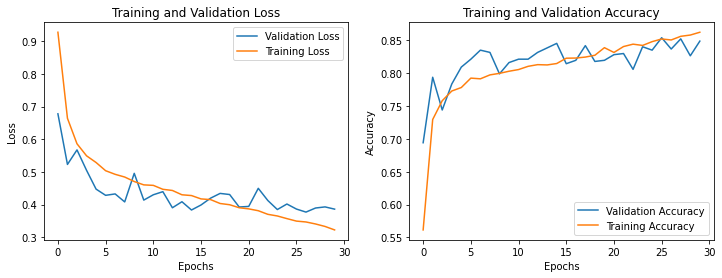

In [22]:
visualize_training_results(history)

In [23]:
# get all the data in the directory split/test and reshape them
test_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                              directory=test_dir,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              class_mode='categorical',
                                              shuffle=False)

Found 587 images belonging to 3 classes.


In [24]:
cnn_model = load_model('./cnn_'+str(date.today())+'.h5')

In [26]:
test_loss, test_acc = cnn_model.evaluate_generator(test_data_gen, 
                                               steps=int(np.ceil(test_data_gen.n / float(batch_size))))

In [27]:
predictions = cnn_model.predict_generator(test_data_gen, steps=int(np.ceil(test_data_gen.n / float(batch_size))))
print('Generated {} predictions'.format(len(predictions)))
print('test acc:', test_acc)
print('test loss:', test_loss)

Generated 587 predictions
test acc: 0.8109028935432434
test loss: 0.5119852423667908


In [28]:
print(type(predictions))
print(predictions.shape)
print(predictions[0])
print(np.argmax(predictions[0]))

<class 'numpy.ndarray'>
(587, 3)
[0.7594691  0.14865986 0.09187105]
0


In [29]:
y_hat_test = np.argmax(predictions, axis=-1)
print(y_hat_test.shape)
print(y_hat_test)

(587,)
[0 2 0 0 0 2 0 0 0 2 1 2 0 2 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0
 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 2 0 0 1 0 1 1 0 0 0 0 2
 2 0 2 1 0 2 2 1 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1

In [30]:
test_generator = image_gen.flow_from_directory(directory=test_dir, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE), 
                                               batch_size = test_data_gen.n,
                                               class_mode='categorical',
                                               shuffle=False)

Found 587 images belonging to 3 classes.


In [31]:
test_images, test_labels = next(test_generator)
print(test_labels.shape)

(587, 3)


In [32]:
y_test = np.argmax(test_labels, axis=-1)
print(y_test.shape)
print(y_test)

(587,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2

In [33]:
print(test_images.shape)
test_img = test_images.reshape(test_images.shape[0], -1)
print(test_img.shape)
print(test_labels.shape)
print(test_labels)
print(test_labels[0])

(587, 150, 150, 3)
(587, 67500)
(587, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[1. 0. 0.]


In [34]:
print(cnn_model.evaluate(test_images, test_labels))

19/19 [==============================] - 6s 303ms/step - loss: 0.5120 - accuracy: 0.8109
[0.5119852423667908, 0.8109028935432434]


In [42]:
ppredictions = cnn_model.predict(test_images)
print(type(ppredictions))
print(ppredictions.shape)
print(cnn_model.predict_classes(test_images))

print(test_generator.classes)
print(list(test_generator.class_indices.keys()))

print(ppredictions[0])
print(np.argmax(ppredictions[0]))
yp_hat_test = np.argmax(ppredictions, axis=-1)
print(yp_hat_test.shape)
print(yp_hat_test)

<class 'numpy.ndarray'>
(587, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 2 2 2
 2 0 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 2 2 2 2 0 0 0 

In [43]:
y = [yp_hat_test[i] for i in range(len(yp_hat_test)) if yp_hat_test[i] == y_hat_test[i]]
print(round(len(y)/len(yp_hat_test), 3))

0.567


In [37]:
accuracy_model = round(accuracy_score(y_test, yp_hat_test), 3)
print(accuracy_model)
#print(round(accuracy_score(test_labels, ppredictions), 3))

0.811


In [38]:
precision_model = round(precision_score(y_test, yp_hat_test, average='micro'), 3)
print(precision_model)
#print(round(precision_score(test_labels, ppredictions, average='micro'), 3))

0.811


In [39]:
recall_model = round(recall_score(y_test, yp_hat_test, average='micro'), 3)
print(recall_model)
#print(round(recall_score(test_labels, ppredictions, average='micro'), 3))

0.811


In [40]:
f1_model = round(f1_score(y_test, yp_hat_test, average='micro'), 3)
print(f1_model)
#print(round(f1_score(test_labels, ppredictions, average='micro'), 3))

0.811


In [41]:
auc_value_model = roc_auc_score(test_labels, ppredictions, multi_class='ovr', average='micro')
auc_value_model

0.9323052857337717

In [ ]:
#fpr_model, tpr_model, threshold_model = roc_curve(y_test, yp_hat_test)

In [ ]:
#roc_auc_model = auc(fpr_model, tpr_model)

In [ ]:
#plt.figure()
#lw=2
#plt.plot(fpr_model, tpr_model, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_model)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive (FP) Rate')
#plt.ylabel('True Positive (TP) Rate')
#plt.title('Receiver operating characteristic for CNN')
#plt.legend(loc='lower right')
#plt.show()